#### Objetivo: generar un modelo que pueda hacer predicciones de ventas

#### Escenario: Eres un científico de datos dentro de la consultoría “El oráculo”, tienes la asignación de trabajar en una empresa de retail para predecir sus ventas semanales a diferentes niveles muestrales, a nivel tienda

#### Datasource: https://www.kaggle.com/code/aslanahmedov/walmart-sales-forecasting

#### Entrega: 06 de Agosto de 2022



# 1. Import Libraries

In [24]:
import pandas as pd
import numpy as np
from prophet import Prophet
import plotly.express as px
from prophet.plot import plot_plotly, plot_components_plotly

# 2. Read Data

In [25]:
df = pd.read_csv('C:/users/mike_/Documents/repos/walmart_forecast/data/clean_data.csv',\
                  parse_dates=['Date']
                  )
#df = pd.read_csv('https://raw.githubusercontent.com/lebesguee/walmart_forecast/main/data/clean_data.csv') # read online

# 2. EDA

In [26]:
#print('rows =', df.shape[0], ', columns =' ,df.shape[1]) # dataset shape
#df.columns #dataset columns
#df.sample(10) #df sample size 10
#df.info() # datatypes and null count
#df['Unnamed: 0'].duplicated().sum() # The Unnamed: 0 is the ID, no duplicates are expected
#df[df.duplicated('Unnamed: 0')] # no duplicates in ID confirmed
#df.describe() #quick stats summary

In [27]:
round(df.isnull().sum().sort_values(ascending=False)*100/len(df), 4) # Porcentaje Descendente de Nulos por Columna
#df.isnull().sum().sort_values(ascending=False) # Conteo Descendente de Nulos por Columna

Unnamed: 0      0.0
Store           0.0
month           0.0
week            0.0
Christmas       0.0
Thanksgiving    0.0
Labor_Day       0.0
Super_Bowl      0.0
Size            0.0
Type            0.0
Unemployment    0.0
CPI             0.0
MarkDown5       0.0
MarkDown4       0.0
MarkDown3       0.0
MarkDown2       0.0
MarkDown1       0.0
Fuel_Price      0.0
Temperature     0.0
IsHoliday       0.0
Weekly_Sales    0.0
Date            0.0
Dept            0.0
year            0.0
dtype: float64

# 3. Tables Creation

### 3.1 Tabla: Total de Ventas por Tienda

In [28]:
TOTAL_SALES_BY_STORE = df.groupby('Store', sort=False)["Weekly_Sales"].sum().reset_index(name ='Total_Sales')
#TOTAL_SALES_BY_STORE.head(10)

# Uncomment to get Table in Currency Format
#TOTAL_SALES_BY_STORE_STR = df.groupby('Store', sort=False)["Weekly_Sales"].sum().reset_index(name ='Total_Sales')
#TOTAL_SALES_BY_STORE_STR['Total_Sales'] = TOTAL_SALES_BY_STORE['Total_Sales'].map("${:,.2f}".format) # formato moneda
#TOTAL_SALES_BY_STORE_STR.head(10)

top_Sales_Store = TOTAL_SALES_BY_STORE.sort_values(by=['Total_Sales'], ascending=False).reset_index(drop=True).head(1) # top n=1 tiendas con más ventas
top_Sales_Store['Total_Sales'] = top_Sales_Store['Total_Sales'].map("${:,.2f}".format)
top_Sales_Store

,Store,Total_Sales
0,20,"$301,401,381.45"


### 3.2 Tablas: Varianza por Tienda y Desviación Estándar por Tienda

In [29]:
VARIANCE_BY_STORE = df.groupby('Store', sort=False)["Weekly_Sales"].var().reset_index(name ='Sales_Variance')
STD_BY_STORE = df.groupby('Store', sort=False)["Weekly_Sales"].std().reset_index(name ='Sales_STD')

#VARIANCE_BY_STORE.head(10)
#STD_BY_STORE.head(10)

TOP1_STD_BY_STORE = STD_BY_STORE.sort_values(by=['Sales_STD'], ascending=False).reset_index(drop=True).head(1) # top n=1 tiendas con más ventas
TOP1_STD_BY_STORE['Sales_STD'] = TOP1_STD_BY_STORE['Sales_STD'].map("${:,.2f}".format)
TOP1_STD_BY_STORE

,Store,Sales_STD
0,14,"$36,936.12"


### 3.3 Coeficiente de Variación Medio

In [30]:
cv = lambda x: np.std(x.values) / np.mean(x.values) * 100
CV_BY_STORE = df[["Store","Weekly_Sales"]].groupby("Store").apply(cv).reset_index(name ='Coefficient_of_Variation')

TOP10_CV_BY_STORE = CV_BY_STORE.sort_values(by=['Coefficient_of_Variation'], ascending=False).reset_index(drop=True).head(10) # top n=1 tiendas con más ventas
TOP10_CV_BY_STORE['Coefficient_of_Variation'] = TOP10_CV_BY_STORE['Coefficient_of_Variation'].map("${:,.2f}".format)
TOP10_CV_BY_STORE

#CV_BY_STORE['Coefficient_of_Variation'].mean() # Promedio de Coeficiente de Variación

,Store,Coefficient_of_Variation
0,3,$331.28
1,44,$265.03
2,38,$258.57
3,30,$251.08
4,5,$246.31
5,42,$244.80
6,37,$243.93
7,33,$241.23
8,43,$239.68
9,36,$234.56


### 3.4 Vista Mensual, Trimestral y Semestral de Ventas Totales y por Tienda 

In [31]:
(df['Date'])

0        2010-02-05
1        2010-02-05
2        2010-02-05
3        2010-02-05
4        2010-02-05
            ...    
420207   2012-10-26
420208   2012-10-26
420209   2012-10-26
420210   2012-10-26
420211   2012-10-26
Name: Date, Length: 420212, dtype: datetime64[ns]

In [32]:
TOTAL_SALES_BY_MONTH = pd.DataFrame(df.set_index('Date')['Weekly_Sales'].resample('M').sum().reset_index(name ='Monthly_Sales'))
TOTAL_SALES_BY_QUARTER = pd.DataFrame(df.set_index('Date')['Weekly_Sales'].resample('Q').sum().reset_index(name ='Quarterly_Sales'))
TOTAL_SALES_BY_SEMESTER = pd.DataFrame(df.set_index('Date')['Weekly_Sales'].resample('2BQ').sum().reset_index(name ='Semester_Sales'))

#TOTAL_SALES_BY_MONTH.head(10)
#TOTAL_SALES_BY_QUARTER.head(10)
#TOTAL_SALES_BY_SEMESTER.head(10)

MONTHLY_SALES_BY_STORE = df.set_index("Date").groupby([pd.Grouper(freq="M"), "Store"])['Weekly_Sales'].sum().reset_index().rename(columns = {'Weekly_Sales':'Total_Sales'})
QUARTERLY_SALES_BY_STORE = df.set_index("Date").groupby([pd.Grouper(freq="Q"), "Store"])['Weekly_Sales'].sum().reset_index().rename(columns = {'Weekly_Sales':'Total_Sales'})
SEMESTER_SALES_BY_STORE = df.set_index("Date").groupby([pd.Grouper(freq="2BQ"), "Store"])['Weekly_Sales'].sum().reset_index().rename(columns = {'Weekly_Sales':'Total_Sales'})

MONTHLY_SALES_BY_STORE
#SEMESTER_SALES_BY_STORE.head(20)

,Date,Store,Total_Sales
0,2010-02-28,1,6308207.10
1,2010-02-28,2,8264347.77
2,2010-02-28,3,1711198.23
3,2010-02-28,4,8299040.36
4,2010-02-28,5,1202728.00
...,...,...,...
1480,2012-10-31,41,5452445.75
1481,2012-10-31,42,2261906.96
1482,2012-10-31,43,2473507.39
1483,2012-10-31,44,1360020.41


In [33]:
MONTHLY_SALES_BY_STORE['Date'].max(), MONTHLY_SALES_BY_STORE['Date'].min(), MONTHLY_SALES_BY_STORE['Date'].sort_values(ascending=True)

(Timestamp('2012-10-31 00:00:00'),
 Timestamp('2010-02-28 00:00:00'),
 0      2010-02-28
 25     2010-02-28
 26     2010-02-28
 27     2010-02-28
 28     2010-02-28
           ...    
 1457   2012-10-31
 1458   2012-10-31
 1459   2012-10-31
 1449   2012-10-31
 1484   2012-10-31
 Name: Date, Length: 1485, dtype: datetime64[ns])

In [34]:
MONTHLY_SALES_BY_STORE_W_RATE = MONTHLY_SALES_BY_STORE.assign(Growth_Rate=MONTHLY_SALES_BY_STORE['Total_Sales'].pct_change())
QUARTERLY_SALES_BY_STORE_W_RATE = QUARTERLY_SALES_BY_STORE.assign(Growth_Rate=QUARTERLY_SALES_BY_STORE['Total_Sales'].pct_change())
SEMESTER_SALES_BY_STORE_W_RATE = SEMESTER_SALES_BY_STORE.assign(Growth_Rate=SEMESTER_SALES_BY_STORE['Total_Sales'].pct_change())

In [35]:
MONTHLY_SALES_BY_STORE_W_RATE

,Date,Store,Total_Sales,Growth_Rate
0,2010-02-28,1,6308207.10,NaN
1,2010-02-28,2,8264347.77,0.310095
2,2010-02-28,3,1711198.23,-0.792942
3,2010-02-28,4,8299040.36,3.849842
4,2010-02-28,5,1202728.00,-0.855076
...,...,...,...,...
1480,2012-10-31,41,5452445.75,0.401271
1481,2012-10-31,42,2261906.96,-0.585157
1482,2012-10-31,43,2473507.39,0.093550
1483,2012-10-31,44,1360020.41,-0.450165


# 4. Modelling

### 4.1 Prophet

In [36]:
_STORE_1_SERIES = MONTHLY_SALES_BY_STORE_W_RATE[MONTHLY_SALES_BY_STORE_W_RATE['Store']==1]
STORE_1_SERIES = _STORE_1_SERIES[['Date', 'Total_Sales']].rename(columns={'Date':'ds', 'Total_Sales':'y'}).reset_index().drop(['index'], axis=1)
STORE_1_SERIES.head(10)

,ds,y
0,2010-02-28,6308207.10
1,2010-03-31,5871991.98
2,2010-04-30,7422801.92
3,2010-05-31,5929938.64
4,2010-06-30,6084081.46
5,2010-07-31,7244483.04
6,2010-08-31,6075952.95
7,2010-09-30,5829793.92
8,2010-10-31,7150699.75
9,2010-11-30,6485547.06


In [37]:
fig = px.line(STORE_1_SERIES, x='ds', y="y")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [38]:
#e fit the model by instantiating a new Prophet object. Call fit method and pass in the historical dataframe STORE_1_SERIES
m = Prophet()
m.fit(STORE_1_SERIES)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\mike_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [39]:
""" 
redictions are then made on a dataframe with a column ds containing the dates for which a prediction is to be made
You can get a suitable dataframe that extends into the future a specified number of days using the helper
method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.
"""

future = m.make_future_dataframe(periods=12, freq='M') # predict next 12 months
future.tail(15)

,ds
30,2012-08-31
31,2012-09-30
32,2012-10-31
33,2012-11-30
34,2012-12-31
35,2013-01-31
36,2013-02-28
37,2013-03-31
38,2013-04-30
39,2013-05-31


In [40]:
"""
The predict method will assign each row in future a predicted value which it names yhat. If you pass in historical
 dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column yhat with the forecast,
  as well as columns for components and uncertainty intervals.
"""
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

c:\Users\mike_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\mike_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,yhat,yhat_lower,yhat_upper
40,2013-06-30,7.635175e+06,7.253304e+06,7.984547e+06
41,2013-07-31,7.114679e+06,6.766096e+06,7.466319e+06
42,2013-08-31,7.595596e+06,7.231783e+06,7.953843e+06
43,2013-09-30,6.691772e+06,6.333085e+06,7.054409e+06
44,2013-10-31,6.966730e+06,6.620077e+06,7.321147e+06


In [41]:
forecast.sample(9)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8,2010-10-31,6.583777e+06,5.894077e+06,6.604989e+06,6.583777e+06,6.583777e+06,-325801.513429,-325801.513429,-325801.513429,-325801.513429,-325801.513429,-325801.513429,0.0,0.0,0.0,6.257976e+06
43,2013-09-30,7.359026e+06,6.333085e+06,7.054409e+06,7.359023e+06,7.359029e+06,-667253.845977,-667253.845977,-667253.845977,-667253.845977,-667253.845977,-667253.845977,0.0,0.0,0.0,6.691772e+06
4,2010-06-30,6.494233e+06,5.962149e+06,6.698580e+06,6.494233e+06,6.494233e+06,-164291.348425,-164291.348425,-164291.348425,-164291.348425,-164291.348425,-164291.348425,0.0,0.0,0.0,6.329942e+06
9,2010-11-30,6.605617e+06,6.257129e+06,6.996598e+06,6.605617e+06,6.605617e+06,29956.107798,29956.107798,29956.107798,29956.107798,29956.107798,29956.107798,0.0,0.0,0.0,6.635574e+06
7,2010-09-30,6.561209e+06,5.935091e+06,6.667849e+06,6.561209e+06,6.561209e+06,-247659.452790,-247659.452790,-247659.452790,-247659.452790,-247659.452790,-247659.452790,0.0,0.0,0.0,6.313550e+06
25,2012-03-31,6.960121e+06,7.559531e+06,8.283985e+06,6.960121e+06,6.960121e+06,964383.324712,964383.324712,964383.324712,964383.324712,964383.324712,964383.324712,0.0,0.0,0.0,7.924504e+06
19,2011-09-30,6.826910e+06,6.629139e+06,7.367929e+06,6.826910e+06,6.826910e+06,178066.262845,178066.262845,178066.262845,178066.262845,178066.262845,178066.262845,0.0,0.0,0.0,7.004976e+06
41,2013-07-31,7.314622e+06,6.766096e+06,7.466319e+06,7.314620e+06,7.314625e+06,-199943.063304,-199943.063304,-199943.063304,-199943.063304,-199943.063304,-199943.063304,0.0,0.0,0.0,7.114679e+06
33,2012-11-30,7.137736e+06,7.172445e+06,7.903095e+06,7.137736e+06,7.137736e+06,394593.512178,394593.512178,394593.512178,394593.512178,394593.512178,394593.512178,0.0,0.0,0.0,7.532329e+06


In [42]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          45 non-null     datetime64[ns]
 1   trend                       45 non-null     float64       
 2   yhat_lower                  45 non-null     float64       
 3   yhat_upper                  45 non-null     float64       
 4   trend_lower                 45 non-null     float64       
 5   trend_upper                 45 non-null     float64       
 6   additive_terms              45 non-null     float64       
 7   additive_terms_lower        45 non-null     float64       
 8   additive_terms_upper        45 non-null     float64       
 9   yearly                      45 non-null     float64       
 10  yearly_lower                45 non-null     float64       
 11  yearly_upper                45 non-null     float64       
 

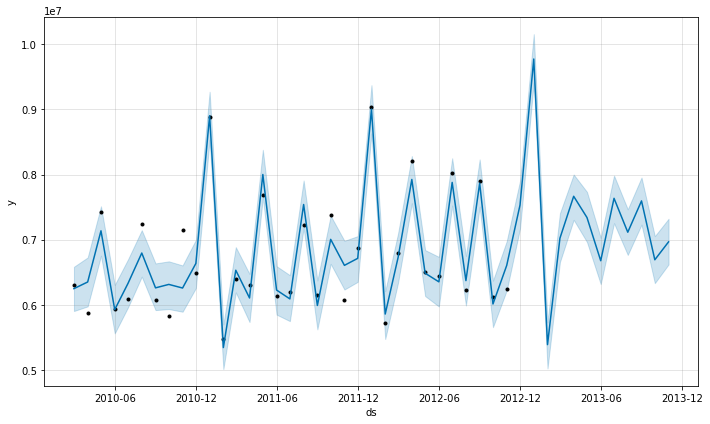

In [43]:
fig1 = m.plot(forecast)

c:\Users\mike_\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



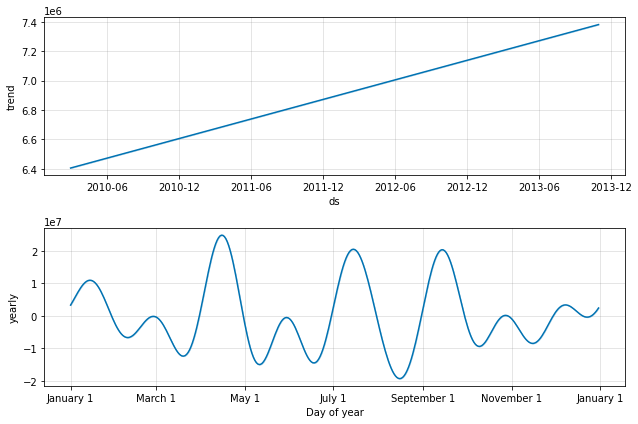

In [44]:
fig2 = m.plot_components(forecast)

In [45]:
plot_plotly(m, forecast)

### Histórico de Ventas

In [46]:
"""

fig = px.line(df, x='Date', y="Weekly_Sales")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

"""

'\n\nfig = px.line(df, x=\'Date\', y="Weekly_Sales")\n\nfig.update_xaxes(\n    rangeslider_visible=True,\n    rangeselector=dict(\n        buttons=list([\n            dict(count=1, label="1m", step="month", stepmode="backward"),\n            dict(count=6, label="6m", step="month", stepmode="backward"),\n            dict(count=1, label="YTD", step="year", stepmode="todate"),\n            dict(count=1, label="1y", step="year", stepmode="backward"),\n            dict(step="all")\n        ])\n    )\n)\nfig.show()\n\n'